## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings;warnings.filterwarnings(action='ignore')

## Read data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
print('학습데이터 수:', train.shape)
print('평가데이터 수:', test.shape)

학습데이터 수: (252289, 19)
평가데이터 수: (79786, 18)


In [4]:
'''
데이터 설명
- sessionID : 세션 ID
- userID : 사용자 ID
- TARGET : 세션에서 발생한 총 조회수
- browser : 사용된 브라우저
- OS : 사용된 기기의 운영체제
- device : 사용된 기기
- new : 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)
- quality : 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)
- duration : 총 세션 시간 (단위: 초)
- bounced : 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)
- transaction : 세션 내에서 발생의 거래의 수
- transaction_revenue : 총 거래 수익
- continent : 세션이 발생한 대륙
- subcontinent : 세션이 발생한 하위 대륙
- country : 세션이 발생한 국가
- traffic_source : 트래픽이 발생한 소스
- traffic_medium : 트래픽 소스의 매체
- keyword : 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정
- referral_path : traffic_medium이 referral인 경우 설정되는 경로
'''
display(train.head())

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


### Traffic Medium
- keyword 변수값을 결정하는 traffic_medium은 웹사이트로 유입되는 트래픽의 구체적인 유형이나 채널을 의미한다.
- 'organic'(무료): 사용자가 검색 엔진에서 특정 키워드를 **검색**하고 결과 페이지에서 나타난 링크로 접속
- 'affiliate': **다른 회사**의 제품이나 서비스를 홍보하고, 그 결과로 발생하는 판매나 클릭에 대해 수수료를 받음
- 'referral': 블로그, 파트너 사이드 등의 다른 웹사이트의 링크를 통해 접속
- 'cpc'(클릭당 비용 발생): **광고** 캠페인(예: Google AdWords)을 통해 웹사이트에 유입
- 'cpm'(천 회 노출당 비용 발생): 디스플레이나 비디오 **광고**에 노출되어 접속
- '(none)'은 traffic_source가 (direct)인  경우이다.<br>
  direct: 사용자가 웹 브라우저에 URL을 직접 입력하거나, 즐겨찾기를 사용해 웹사이트에 직접 접속하는 경우
- '(not set)': 결측치로 봐야함

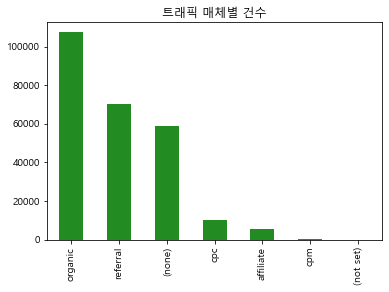

In [12]:
train.traffic_medium.value_counts().plot.bar(title="트래픽 매체별 건수", color='forestgreen')
plt.show()

In [ ]:
# 광고로 접속한 cpc, cpm은 ad(광고)로 변경한다.
train['traffic_medium'] = train['traffic_medium'].replace('cpc','ad').replace('cpm','ad')
test['traffic_medium'] = test['traffic_medium'].replace('cpc','ad').replace('cpm','ad')

In [18]:
# (not set)은 결측치로 학습데이터 내 트래픽 소스의 최빈값으로 채운다.
mode = train.groupby('traffic_source')['traffic_medium'].agg(lambda x: x.mode()[0])
ease = train.query('traffic_medium == "(not set)"')['traffic_source'].map(mode)
train.loc[ease.index, 'traffic_medium'] = ease.values

ease = test.query('traffic_medium == "(not set)"')['traffic_source'].map(mode)
test.loc[ease.index, 'traffic_medium'] = ease.values

### Keyword

In [40]:
# 검색했는지 아닌지, 카테고리의 target mean, 넘버의 target mean을 사용해본다.
ease = train.copy()
ease[['KW_c', 'KW_n']]= ease.keyword.str.split('_', expand=True)[[0,2]]

In [41]:
ease.groupby('KW_c')['TARGET'].mean()

KW_c
Category1     5.476480
Category10    1.625981
Category11    3.144485
Category12    1.291457
Category2     2.771131
Category3     5.224832
Category4     2.676617
Category5     4.276596
Category6     5.694915
Category7     1.140625
Category8     3.857970
Category9     1.263761
Name: TARGET, dtype: float64

In [59]:
ease.RP_c.value_counts()

Category1     18687
Category2     13682
Category11    12165
Category13     9775
Category3      7751
Category6      6918
Category5      5268
Category8      4584
Category4      3766
Category12     3452
Category7      3023
Category9      1378
Category10      733
Name: RP_c, dtype: int64

In [64]:
ease.groupby(['RP_c','RP_n'])['TARGET'].size().sort_values()

RP_c        RP_n
Category13  1230       1
Category11  1573       1
Category12  0034       1
            0613       1
            0672       1
                    ... 
Category2   0063    2367
Category7   0001    2984
Category6   0008    3232
Category2   0018    3987
Category3   0013    7218
Name: TARGET, Length: 1577, dtype: int64

In [58]:
ease.groupby('RP_c')['TARGET'].mean()

RP_c
Category1     6.501258
Category10    4.480218
Category11    2.398438
Category12    3.557648
Category13    1.940051
Category2     2.108537
Category3     3.012902
Category4     1.973447
Category5     2.161352
Category6     3.900116
Category7     2.479656
Category8     2.785777
Category9     4.447750
Name: TARGET, dtype: float64

In [42]:
ease.groupby('KW_n')['TARGET'].mean()

KW_n
000    6.354005
001    5.545455
002    2.307692
003    6.594637
004    1.800000
         ...   
613    1.000000
614    2.000000
615    1.000000
616    1.000000
617    5.000000
Name: TARGET, Length: 618, dtype: float64

In [85]:
train.query('country=="(not set)"')

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
978,SESSION_000978,USER_000912,1.0,Safari (in-app),iOS,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),google,cpc,Category9,NaN
1065,SESSION_001065,USER_000991,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
2012,SESSION_002012,USER_001844,4.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
2781,SESSION_002781,USER_002546,1.0,Chrome,Android,mobile,0,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
3077,SESSION_003077,USER_002546,2.0,Chrome,Android,mobile,0,1.0,8.0,0,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250035,SESSION_250035,USER_204316,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
250612,SESSION_250612,USER_204769,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),analytics.google.com,referral,NaN,Category3_Path_0013
250654,SESSION_250654,USER_204805,3.0,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
251144,SESSION_251144,USER_205183,1.0,Internet Explorer,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),youtube.com,referral,NaN,Category13_Path_0029


In [86]:
test.query('country=="(not set)"')

,sessionID,userID,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
538,SESSION_252827,USER_206517,Internet Explorer,Windows,desktop,1,1.0,194.0,0,0.0,0.0,(not set),(not set),(not set),google,organic,Category2_Keyword_622,NaN
1465,SESSION_253754,USER_108579,Android Webview,Android,mobile,0,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),away.vk.com,referral,NaN,Category6_Path_0930
3894,SESSION_256183,USER_209473,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
4217,SESSION_256506,USER_209744,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
5476,SESSION_257765,USER_210785,Chrome,Macintosh,desktop,1,2.0,1214.0,0,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,SESSION_330202,USER_267509,Chrome,Linux,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),dfa,cpm,NaN,NaN
78628,SESSION_330917,USER_268093,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),youtube.com,referral,NaN,Category11_Path_0236
78973,SESSION_331262,USER_268093,Chrome,Windows,desktop,0,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),youtube.com,referral,NaN,Category11_Path_0236
79105,SESSION_331394,USER_268093,Chrome,Windows,desktop,0,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),youtube.com,referral,NaN,Category11_Path_0236


In [43]:
train.isna().sum()

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

In [46]:
train[train['referral_path'].notna()].traffic_medium.value_counts()

referral    70047
(none)      21135
Name: traffic_medium, dtype: int64

In [52]:
ease[['RP_c', 'RP_n']] = train['referral_path'].str.split('_', expand=True)[[0,2]]

In [54]:
ease.groupby('RP_n')['RP_c'].nunique().value_counts()

1    1577
Name: RP_c, dtype: int64

In [57]:
ease[['KW_c','RP_c']].drop_duplicates()

,KW_c,RP_c
0,Category8,NaN
2,NaN,NaN
4,NaN,Category6
5,Category9,NaN
6,NaN,Category7
8,NaN,Category5
9,Category1,NaN
12,NaN,Category11
18,NaN,Category8
19,Category10,NaN


In [69]:
train.groupby('traffic_source')['traffic_medium'].unique()

traffic_source
(direct)                       [(none), cpm]
Partners                         [affiliate]
adwords.google.com                [referral]
amp.reddit.com                    [referral]
analytics.google.com              [referral]
                                   ...      
wikihow.com                       [referral]
yahoo                              [organic]
yandex                             [organic]
youtube.com                       [referral]
youtube.thinkwithgoogle.com       [referral]
Name: traffic_medium, Length: 168, dtype: object

In [70]:
train.query('traffic_medium=="cpm"')['traffic_source'].unique()

array(['google', 'dfa', '(direct)'], dtype=object)

In [72]:
train.groupby('traffic_medium')['traffic_source'].unique()

traffic_medium
(none)                                              [(direct)]
affiliate                                           [Partners]
cpc                                                   [google]
cpm                                    [google, dfa, (direct)]
organic              [google, bing, baidu, yahoo, ask, yandex]
referral     [groups.google.com, youtube.com, google.com, g...
Name: traffic_source, dtype: object

In [78]:
ease2 = train.query('traffic_medium=="referral"')[['country','traffic_source']].drop_duplicates()

In [81]:
ease2.groupby('traffic_source')['country'].nunique() == 2

traffic_source
adwords.google.com             False
amp.reddit.com                  True
analytics.google.com           False
arstechnica.com                False
au.search.yahoo.com            False
                               ...  
web.telegram.org               False
web.whatsapp.com                True
wikihow.com                     True
youtube.com                    False
youtube.thinkwithgoogle.com    False
Name: country, Length: 159, dtype: bool

In [83]:
ease2.groupby('country')['traffic_source'].unique()

country
(not set)      [youtube.com, keep.google.com, analytics.googl...
Afghanistan                                        [youtube.com]
Albania                                [youtube.com, google.com]
Algeria        [youtube.com, google.com, lisham-web.blogspot....
Andorra                                            [youtube.com]
                                     ...                        
Venezuela      [youtube.com, support.google.com, mail.google....
Vietnam        [youtube.com, analytics.google.com, m.facebook...
Yemen                                              [youtube.com]
Zambia                                             [youtube.com]
Zimbabwe                                           [youtube.com]
Name: traffic_source, Length: 193, dtype: object

In [94]:
common_portal = ['google', '(direct)', 'youtube.com', 'analytics.google.com', 'Partners',
                 'sites.google.com', 'google.com', 'bing', 'reddit.com', 'qiita.com','yahoo']

In [95]:
train.query('traffic_source not in @common_portal').groupby('country')['traffic_source'].unique()

country
(not set)               [dfa, keep.google.com, quora.com, baidu, mail....
Algeria                        [lisham-web.blogspot.com, mail.google.com]
Argentina               [blog.golang.org, productforums.google.com, go...
Armenia                                             [away.vk.com, yandex]
Australia               [googleads.g.doubleclick.net, dfa, lunametrics...
                                              ...                        
United Arab Emirates       [quora.com, t.co, youtube.thinkwithgoogle.com]
United Kingdom          [yahoo, blog.golang.org, support.google.com, m...
United States           [groups.google.com, pinterest.com, mail.google...
Venezuela                           [support.google.com, mail.google.com]
Vietnam                 [m.facebook.com, l.facebook.com, mail.google.c...
Name: traffic_source, Length: 107, dtype: object

In [98]:
ease3 = train[train['traffic_source'].apply(lambda x: 'facebook' in x)]

In [104]:
ease3.groupby('traffic_source')['country'].unique()

traffic_source
business.facebook.com                                             [France]
facebook.com             [Taiwan, Israel, Canada, Germany, Netherlands,...
fr-fr.facebook.com                                                [France]
l.facebook.com           [Ukraine, United States, Israel, Portugal, Tai...
lm.facebook.com          [Bahamas, United States, India, Germany, Finla...
m.facebook.com           [United States, Vietnam, Taiwan, France, Malay...
web.facebook.com                                                  [Poland]
Name: country, dtype: object

In [88]:
train.traffic_source.value_counts().head(10).index

Index(['google', '(direct)', 'youtube.com', 'analytics.google.com', 'Partners',
       'sites.google.com', 'google.com', 'bing', 'reddit.com', 'qiita.com'],
      dtype='object')

In [84]:
train.applymap(lambda x: x=="(not set)").sum()

sessionID                 0
userID                    0
TARGET                    0
browser                   0
OS                     2592
device                    0
new                       0
quality                   0
duration                  0
bounced                   0
transaction               0
transaction_revenue       0
continent               336
subcontinent            336
country                 336
traffic_source            0
traffic_medium            0
keyword                   0
referral_path             0
dtype: int64

In [80]:
ease2[ease2.groupby('traffic_source')['country'].nunique() == 2]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [71]:
train.traffic_source.unique()

array(['google', '(direct)', 'Partners', 'groups.google.com',
       'youtube.com', 'google.com', 'bing', 'google.co.jp',
       'analytics.google.com', 'baidu', 'quora.com',
       'googleads.g.doubleclick.net', 'pinterest.com', 'mail.google.com',
       'dealspotr.com', 'qiita.com', 'l.facebook.com', 'reddit.com',
       'sites.google.com', 'blog.golang.org', 'support.google.com',
       'yahoo', 'dfa', 't.co', 'lunametrics.com', 'docs.google.com',
       'adwords.google.com', 's0.2mdn.net', 'm.baidu.com',
       'm.facebook.com', 'int.search.tb.ask.com', 'google.com.br',
       'google.es', 'arstechnica.com', 'msn.com', 'tw.search.yahoo.com',
       'facebook.com', 'google.de', 'hangouts.google.com',
       'duckduckgo.com', 'r.search.aol.com', 'my.yahoo.com',
       'google.co.za', 'au.search.yahoo.com', 'in.search.yahoo.com',
       'outlook.live.com', 'productforums.google.com', 'ask',
       'google.co.id', 'google.co.uk', 'myactivity.google.com',
       'google.com.ua', 'google

In [50]:
train[train['referral_path'].notna()].query('traffic_medium == "(none)"').referral_path.unique()

array(['Category1', 'Category6_Path_0008', 'Category3_Path_0174',
       'Category6_Path_0297', 'Category6_Path_0314',
       'Category6_Path_0320', 'Category6_Path_0351',
       'Category6_Path_0382', 'Category6_Path_0549',
       'Category6_Path_0027', 'Category6_Path_0646',
       'Category6_Path_0782', 'Category6_Path_0556',
       'Category6_Path_0849', 'Category6_Path_0858',
       'Category6_Path_1039', 'Category6_Path_1170',
       'Category6_Path_1309', 'Category6_Path_1361',
       'Category6_Path_1398', 'Category6_Path_1423',
       'Category6_Path_1435', 'Category6_Path_1459',
       'Category11_Path_1506', 'Category6_Path_1507',
       'Category6_Path_1508', 'Category6_Path_1509',
       'Category6_Path_1510', 'Category6_Path_1512',
       'Category6_Path_1515', 'Category6_Path_1518',
       'Category6_Path_1519', 'Category6_Path_1520',
       'Category6_Path_1522', 'Category10_Path_1554',
       'Category10_Path_1556'], dtype=object)

In [51]:
train.groupby('referral_path')[['traffic_medium']].nunique().value_counts()

traffic_medium
1                 1573
2                    5
dtype: int64

In [47]:
train.traffic_medium.value_counts()

organic      107372
referral      70047
(none)        59022
cpc            9978
affiliate      5369
cpm             501
Name: traffic_medium, dtype: int64

In [39]:
ease.groupby(2)[0].nunique().value_counts()

1    618
Name: 0, dtype: int64

In [33]:
ease[[0,3]].drop

Category8     103584
Category9       3488
Category11      1931
Category1       1318
Category10      1147
Category6       1121
Category2        769
Category4        402
Category12       398
Category3        298
Category5         94
Category7         64
Name: 0, dtype: int64

In [35]:
ease[1].value_counts()

Keyword    4066
Name: 1, dtype: int64

In [36]:
ease[2].value_counts()

003    634
000    387
018    288
006    250
565    219
      ... 
273      1
271      1
270      1
269      1
617      1
Name: 2, Length: 618, dtype: int64

In [27]:
# target값간의 관계
train.groupby('traffic_medium')['TARGET'].mean()

traffic_medium
(none)       4.581021
affiliate    3.112125
cpc          2.911606
cpm          3.047904
organic      3.842613
referral     2.514340
Name: TARGET, dtype: float64

<AxesSubplot:xlabel='traffic_medium', ylabel='TARGET'>

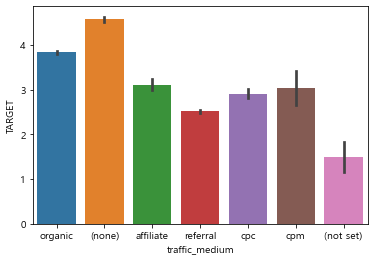

In [5]:
sns.barplot(data=data, x='traffic_medium', y='TARGET')

In [13]:
X_train['keyword'].sort_values().unique()

array(['Category10', 'Category11', 'Category12', 'Category1_Keyword_000',
       'Category1_Keyword_001', 'Category1_Keyword_002',
       'Category1_Keyword_006', 'Category1_Keyword_011',
       'Category1_Keyword_017', 'Category1_Keyword_020',
       'Category1_Keyword_025', 'Category1_Keyword_027',
       'Category1_Keyword_035', 'Category1_Keyword_036',
       'Category1_Keyword_037', 'Category1_Keyword_039',
       'Category1_Keyword_041', 'Category1_Keyword_042',
       'Category1_Keyword_044', 'Category1_Keyword_060',
       'Category1_Keyword_062', 'Category1_Keyword_065',
       'Category1_Keyword_067', 'Category1_Keyword_069',
       'Category1_Keyword_073', 'Category1_Keyword_082',
       'Category1_Keyword_083', 'Category1_Keyword_085',
       'Category1_Keyword_088', 'Category1_Keyword_090',
       'Category1_Keyword_094', 'Category1_Keyword_107',
       'Category1_Keyword_112', 'Category1_Keyword_121',
       'Category1_Keyword_125', 'Category1_Keyword_126',
       'Catego

In [9]:
X_train.groupby('keyword')['traffic_medium'].unique().value_counts()

[organic]         505
[cpc]             108
[cpc, organic]      1
[cpc, organic]      1
[cpc, organic]      1
[cpc, organic]      1
[cpc, organic]      1
[organic, cpc]      1
[cpc, organic]      1
[organic, cpc]      1
[organic, cpc]      1
[organic, cpc]      1
Name: traffic_medium, dtype: int64

In [6]:
X_train.traffic_medium.value_counts()

organic      107370
referral      70047
(none)        59022
cpc            9978
affiliate      5365
cpm             501
(not set)         6
Name: traffic_medium, dtype: int64

In [7]:
X_test.traffic_medium.value_counts()

organic      35894
referral     19814
(none)       19367
affiliate     2801
cpc           1798
cpm            106
(not set)        6
Name: traffic_medium, dtype: int64

In [5]:
X_train.traffic_source.unique()

array(['google', '(direct)', 'Partners', 'groups.google.com',
       'youtube.com', 'google.com', 'bing', 'google.co.jp',
       'analytics.google.com', 'baidu', 'quora.com',
       'googleads.g.doubleclick.net', 'pinterest.com', 'mail.google.com',
       'dealspotr.com', 'qiita.com', 'l.facebook.com', 'reddit.com',
       'sites.google.com', 'blog.golang.org', 'support.google.com',
       'yahoo', 'dfa', 't.co', 'lunametrics.com', 'docs.google.com',
       'adwords.google.com', 's0.2mdn.net', 'm.baidu.com',
       'm.facebook.com', 'int.search.tb.ask.com', 'google.com.br',
       'google.es', 'arstechnica.com', 'msn.com', 'tw.search.yahoo.com',
       'facebook.com', 'google.de', 'hangouts.google.com',
       'duckduckgo.com', 'r.search.aol.com', 'my.yahoo.com',
       'google.co.za', 'au.search.yahoo.com', 'in.search.yahoo.com',
       'outlook.live.com', 'productforums.google.com', 'ask',
       'google.co.id', 'google.co.uk', 'myactivity.google.com',
       'google.com.ua', 'google

In [10]:
X_train.traffic_medium.unique()

array(['organic', '(none)', 'affiliate', 'referral', 'cpc', 'cpm',
       '(not set)'], dtype=object)

In [13]:
X_train.query('traffic_medium == "(not set)"').traffic_source.unique()

array(['Partners', 'google'], dtype=object)

In [5]:
# keyword와 referral_path에 결측치가 있다.
X_train.isna().sum()

sessionID                   0
userID                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

In [9]:
X_train.traffic_source.unique()

array(['google', '(direct)', 'Partners', 'groups.google.com',
       'youtube.com', 'google.com', 'bing', 'google.co.jp',
       'analytics.google.com', 'baidu', 'quora.com',
       'googleads.g.doubleclick.net', 'pinterest.com', 'mail.google.com',
       'dealspotr.com', 'qiita.com', 'l.facebook.com', 'reddit.com',
       'sites.google.com', 'blog.golang.org', 'support.google.com',
       'yahoo', 'dfa', 't.co', 'lunametrics.com', 'docs.google.com',
       'adwords.google.com', 's0.2mdn.net', 'm.baidu.com',
       'm.facebook.com', 'int.search.tb.ask.com', 'google.com.br',
       'google.es', 'arstechnica.com', 'msn.com', 'tw.search.yahoo.com',
       'facebook.com', 'google.de', 'hangouts.google.com',
       'duckduckgo.com', 'r.search.aol.com', 'my.yahoo.com',
       'google.co.za', 'au.search.yahoo.com', 'in.search.yahoo.com',
       'outlook.live.com', 'productforums.google.com', 'ask',
       'google.co.id', 'google.co.uk', 'myactivity.google.com',
       'google.com.ua', 'google

In [6]:
X_train['keyword'] = X_train['keyword'].str.split('_', expand=True)[0]
X_test['keyword'] = X_test['keyword'].str.split('_', expand=True)[0]

X_train['keyword'].fillna(X_train['keyword'].mode()[0], inplace=True)
X_test['keyword'].fillna(X_test['keyword'].mode()[0], inplace=True)

In [6]:
X_train['referral_path'] = X_train['referral_path'].str.split('_', expand=True)[0]
X_test['referral_path'] = X_test['referral_path'].str.split('_', expand=True)[0]

X_train['referral_path'].fillna(X_train['referral_path'].mode()[0], inplace=True)
X_test['referral_path'].fillna(X_test['referral_path'].mode()[0], inplace=True)

In [7]:
# 불필요한 열 제거
X_train.drop(['keyword'], axis=1, inplace=True)
X_test.drop(['keyword'], axis=1, inplace=True)

In [8]:
# Category type으로 변경
categorical_features = ['browser', 'OS', 'device', 'new', 'bounced', 'continent', 'subcontinent',
                        'country', 'traffic_source', 'traffic_medium','referral_path']
                        
for i in categorical_features:
    X_train[i] = X_train[i].astype('category')
    X_test[i] = X_test[i].astype('category')

### 변수 제거하기

In [ ]:
# ID열 제거하기
X_train.drop(['sessionID','userID'], axis=1, inplace=True)
X_test.drop(['sessionID','userID'], axis=1, inplace=True)

## HyperParameter Tunning

In [9]:
model = CatBoostRegressor(cat_features = categorical_features, random_state=2024, verbose=False)

## Kfold

In [10]:
KF = KFold(n_splits = 3, shuffle = True, random_state = 2024)

cat_pred = np.zeros(X_test.shape[0])
rmse_list = []
for tr_idx, val_idx in KF.split(X_train, y_train):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    model.fit(tr_x, tr_y)
    pred = model.predict(val_x)
    rmse = mean_squared_error(val_y, pred)**0.5
    rmse_list.append(rmse)
    
    sub_pred = np.array(model.predict(X_test)) / 3  # averaging
    cat_pred += sub_pred
print(f'{model.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

CatBoostRegressor의 10fold 평균 RMSE는 2.7332039875781162


In [11]:
# 0보다 작은 값을 0으로 보정한다.
cat_pred = [0 if i < 0 else i for i in cat_pred]

In [12]:
# feature importance
model.get_feature_importance()

array([ 1.94840673,  3.35521277,  1.29113915,  4.30298655, 41.66174928,
       28.25875626,  0.40794133,  0.66779683,  1.82488301,  2.77130112,
        6.87719499,  1.21923291,  1.5348814 ,  2.56468709,  1.31383057])

## Save data

In [13]:
sample = pd.read_csv('data/submission/sample_submission.csv')
sample['TARGET'] = cat_pred

In [14]:
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
filename = f'./data/submission/{date}'
sample.to_csv(f'{filename}.csv', index=False)
print(f'{filename} is saved.')

./data/submission/20240221_0002 is saved.
